# Mojito Processing Pipeline

Demonstrates the full TDI data processing pipeline using the `process_pipeline` utility from `MojitoProcessor`.

The pipeline applies the following steps in order:

| Step | Operation | Default |
|------|-----------|------|
| 1 | High-pass filter | cutoff = 5×10⁻⁶ Hz, order = 2 |
| 2 | Trim edge artefacts | 2.2% from each end |
| 3 | Truncate to working length | configurable |
| 4 | Downsample | configurable target rate |
| 5 | Tukey window | α = 0.025 |

The final cell verifies consistency by comparing the periodogram against the Mojito L1 noise estimate.

In [3]:
%load_ext autoreload
%autoreload 2

import logging
import numpy as np
import matplotlib.pyplot as plt

from MojitoProcessor import load_mojito_l1, process_pipeline

# Show pipeline progress at INFO level
logging.basicConfig(
    level=logging.INFO,
    format='%(name)s | %(message)s',
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data

In [ ]:
mojito_data_file = "../Mojito_Data/NOISE_731d_0.25s_L1_source0_0_20251206T220508924302Z.h5"

# Load in the data file
data = load_mojito_l1(mojito_data_file)


print(f"Loaded: {data.n_samples:,} samples @ {data.fs} Hz ({data.duration/86400:.2f} days)")
print(f"Channels: {list(data.tdis.keys())}")
print(f"Central frequency: {CENTRAL_FREQ:.3e} Hz")

Loading: ../Mojito_Data/NOISE_731d_0.25s_L1_source0_0_20251206T220508924302Z.h5
File size: 34701.86 MB

Metadata:
  Pipeline: mojito-noise-simple-total-extended-total
  Laser frequency: 2.816e+14 Hz

TDI Sampling:
  t0 = 97729889.328 s (TCB)
  fs = 4.000 Hz, dt = 0.250 s
  Duration: 63116300.0 s (730.51 days)
  Samples: 252,465,200
  ✓ Loaded TDI-X: shape=(252465200,)
  ✓ Loaded TDI-Y: shape=(252465200,)
  ✓ Loaded TDI-Z: shape=(252465200,)
  ✓ Loaded TDI-A: shape=(252465200,)
  ✓ Loaded TDI-E: shape=(252465200,)
  ✓ Loaded TDI-T: shape=(252465200,)

Pre-computed Noise Estimates:
  Frequency range: 1.00e-05 to 1.00e+00 Hz
  Frequency bins: 1000
  XYZ covariance: 731 segments x 1000 freqs x 3x3
  AET covariance: (731, 1000, 3, 3)

✓ Successfully loaded mojito data
Loaded: 252,465,200 samples @ 4.0 Hz (730.51 days)
Channels: ['X', 'Y', 'Z', 'A', 'E', 'T']
Central frequency: 2.816e+14 Hz


## 2. Run the Processing Pipeline

All pipeline parameters are configurable here. The pipeline runs in this order:

```
bandpass/highpass filter → downsample → trim → truncate → window
```

**Downsampling guidance** — the science band extends to ~0.1 Hz:
- `target_fs = 0.4 Hz` → Nyquist = 0.2 Hz, 10× compression (recommended)
- `target_fs = 1.0 Hz` → Nyquist = 0.5 Hz, 4× compression

If setting `lowpass_cutoff`, ensure `target_fs >= 2 × lowpass_cutoff` to avoid aliasing.

In [4]:
# ── Pipeline parameters ───────────────────────────────────────────────────────
CHANNELS       = ['X', 'Y', 'Z']
HP_CUTOFF      = 5e-6   # Hz  — high-pass cutoff (always applied)
LP_CUTOFF      = 0.2   # Hz  — set e.g. 0.01 for a band-pass; None = high-pass only
FILTER_ORDER   = 2      # Butterworth filter order
TARGET_FS      = 0.02    # Hz  — target sampling rate (None = no downsampling)
KAISER_WINDOW = 31.0    # Kaiser window beta parameter for anti-aliasing during downsampling (higher = more aggressive)
TRIM_FRACTION  = 0.022  # fraction of post-downsample duration trimmed from each end
TRUNCATE_DAYS  = 4.0    # days to keep after trimming (None = keep all)
WINDOW         = 'tukey'
WINDOW_ALPHA   = 0.025
# ─────────────────────────────────────────────────────────────────────────────

sp = process_pipeline(
    data,
    channels=CHANNELS,
    highpass_cutoff=HP_CUTOFF,
    lowpass_cutoff=LP_CUTOFF,
    filter_order=FILTER_ORDER,
    target_fs=TARGET_FS,
    kaiser_window = KAISER_WINDOW,
    trim_fraction=TRIM_FRACTION,
    truncate_days=TRUNCATE_DAYS,
    window=WINDOW,
    window_alpha=WINDOW_ALPHA,
)

MojitoProcessor.SigProcessing | Step 1/5 | Init: 252465200 samples @ 4 Hz (730.51 days), channels=['X', 'Y', 'Z']
MojitoProcessor.SigProcessing | Step 2/5 | Band-pass: [5.0e-06, 2.0e-01] Hz, order=2 (zero-phase Butterworth)
MojitoProcessor.SigProcessing | Step 3/5 | Resample: 4 Hz → 0.02 Hz, 252465200 → 1262326 samples (Nyquist = 0.01 Hz)
MojitoProcessor.SigProcessing | Step 4/5 | Trim: 385.7 h from each end → 1206784 samples (698.37 days)
MojitoProcessor.SigProcessing | Step 5/5 | Truncate: 6912 samples (4.00 days)
MojitoProcessor.SigProcessing | Step 6/6 | Window: tukey (alpha=0.025) | Ready — N=6912, fs=0.02 Hz, dt=50 s, T=4.0000 days


## 3. Compute FFT and Periodogram

The one-sided periodogram estimate is:

$$\hat{S}(f_k) = \frac{2\,\Delta t}{N} \left|\tilde{n}(f_k)\right|^2$$

where $\tilde{n}$ is the FFT of the windowed, normalised time series.

In [ ]:
# Convert from frequency to fractional frequency
CENTRAL_FREQ = data.metadata['laser_frequency']

freq     = np.fft.rfftfreq(sp.N, d=sp.dt)
fft_xyz  = {ch: np.fft.rfft(sp.data[ch]) / CENTRAL_FREQ for ch in sp.channels}

# XYZ → AET
fft_aet = {
    'A': (fft_xyz['Z'] - fft_xyz['X']) / np.sqrt(2),
    'E': (fft_xyz['X'] - 2*fft_xyz['Y'] + fft_xyz['Z']) / np.sqrt(6),
    'T': (fft_xyz['X'] + fft_xyz['Y'] + fft_xyz['Z']) / np.sqrt(3),
}

# One-sided periodogram  S_hat(f) = 2*dt/N * |X(f)|^2
psd_norm    = 2 * sp.dt / sp.N
pgram_xyz   = {ch: psd_norm * np.abs(fft_xyz[ch])**2 for ch in sp.channels}
pgram_aet   = {ch: psd_norm * np.abs(fft_aet[ch])**2 for ch in ['A', 'E', 'T']}

# Mojito L1 noise estimate (segment 0 diagonal = auto-PSD)
l1_xyz = {ch: data.noise_cov_xyz[0][:, i, i] / CENTRAL_FREQ**2
          for i, ch in enumerate(['X', 'Y', 'Z'])}
l1_aet = {ch: data.noise_cov_aet[0][:, i, i] / CENTRAL_FREQ**2
          for i, ch in enumerate(['A', 'E', 'T'])}

print(f"Frequency resolution: {freq[1]:.3e} Hz")
print(f"Frequency range:      [{freq[1]:.3e}, {freq[-1]:.3e}] Hz")
print(f"Nyquist:              {sp.fs/2:.4g} Hz")

Frequency resolution: 2.894e-06 Hz
Frequency range:      [2.894e-06, 1.000e-02] Hz
Nyquist:              0.01 Hz


## 4. Periodogram vs Mojito L1 Estimate

A good processing pipeline produces a periodogram (coloured lines) that traces the Mojito L1 noise model (red dashed) throughout the science band (1×10⁻⁴ to 1×10⁻¹ Hz). Deviations at the lowest frequencies indicate residual artefacts from filtering or insufficient trimming.

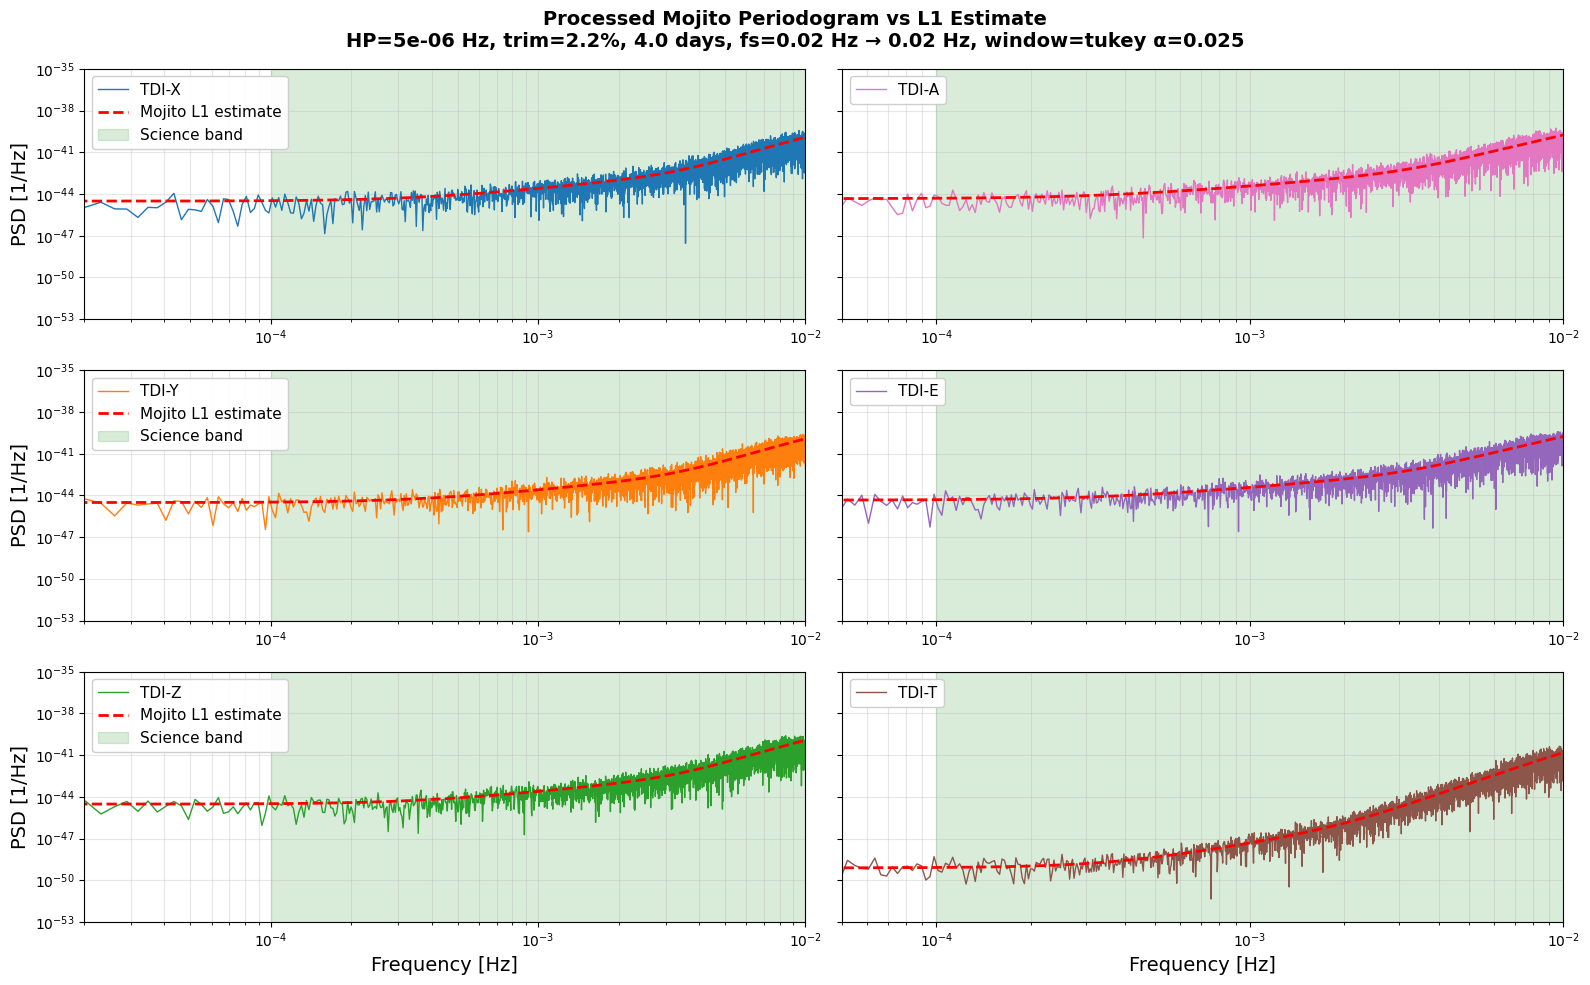

In [7]:
nyquist    = sp.fs / 2
xyz_colors = ['C0', 'C1', 'C2']
aet_colors = ['#e377c2', '#9467bd', '#8c564b']

fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=False, sharey=True)

for i, ch in enumerate(['X', 'Y', 'Z']):
    ax = axes[i, 0]
    ax.loglog(freq[1:], pgram_xyz[ch][1:],
              linewidth=1.0, color=xyz_colors[i], label=f'TDI-{ch}')
    ax.loglog(data.noise_freqs, l1_xyz[ch],
              linestyle='dashed', color='red', linewidth=2.0, label='Mojito L1 estimate')
    ax.axvspan(1e-4, 1e-1, alpha=0.15, color='green', label='Science band')
    ax.set_xlim(2e-5, min(2e-1, nyquist))
    ax.set_ylim(1e-53, 1e-35)
    ax.set_ylabel('PSD [1/Hz]', fontsize=14)
    ax.grid(True, which='both', alpha=0.3)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)

for i, ch in enumerate(['A', 'E', 'T']):
    ax = axes[i, 1]
    ax.loglog(freq[1:], pgram_aet[ch][1:],
              linewidth=1.0, color=aet_colors[i], label=f'TDI-{ch}')
    ax.loglog(data.noise_freqs, l1_aet[ch],
              linestyle='dashed', color='red', linewidth=2.0)
    ax.axvspan(1e-4, 1e-1, alpha=0.15, color='green')
    ax.set_xlim(5e-5, nyquist)
    ax.set_ylim(1e-53, 1e-35)
    ax.grid(True, which='both', alpha=0.3)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)

axes[2, 0].set_xlabel('Frequency [Hz]', fontsize=14)
axes[2, 1].set_xlabel('Frequency [Hz]', fontsize=14)

fig.suptitle(
    f'Processed Mojito Periodogram vs L1 Estimate\n'
    f'HP={HP_CUTOFF:.0e} Hz, trim={TRIM_FRACTION:.1%}, '
    f'{TRUNCATE_DAYS} days, fs={TARGET_FS} Hz → {sp.fs} Hz, '
    f'window={WINDOW} α={WINDOW_ALPHA}',
    fontsize=14, fontweight='bold',
)
plt.tight_layout()
plt.show()